In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.io import fits
from astropy import units as u
from astropy import constants as c

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load spatial legacy map IC3392_individual.fits 
# --------- file location (edit if needed) ----------
binning_path = Path("IC3392_SPATIAL_BINNING_maps.fits")
print("Loading:", binning_path.resolve())
with fits.open(binning_path) as hdul:
    # check data structure and header
    print(hdul.info())
    binning_primary = hdul[0]
    binning_BINID   = hdul[1].data
    binning_FLUX    = hdul[2].data
    binning_SNR     = hdul[3].data
    binning_SNRBIN  = hdul[4].data
    binning_XBIN    = hdul[5].data
    binning_YBIN    = hdul[6].data
    binning_hdr     = hdul[1].header
    hdul.close()

binning_hdr


Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps.fits
Filename: IC3392_SPATIAL_BINNING_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        26   (437, 438)   float64   
  3  SNR           1 ImageHDU        26   (437, 438)   float64   
  4  SNRBIN        1 ImageHDU        26   (437, 438)   float64   
  5  XBIN          1 ImageHDU        26   (437, 438)   float64   
  6  YBIN          1 ImageHDU        26   (437, 438)   float64   
None


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [3]:
# Load the legacy data
# --------- file location (edit if needed) ----------
legacy_path = Path("IC3392_DESI_grih.fits")
print("Loading:", legacy_path.resolve())
with fits.open(legacy_path) as hdul:
    # check data structure and header
    print(hdul.info())
    legacy = hdul[0]
    legacy_hdr     = hdul[0].header
    hdul.close()

legacy_hdr


Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_DESI_grih.fits
Filename: IC3392_DESI_grih.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (3000, 3000, 4)   float32   
None


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 3000 / length of data axis 1                          
NAXIS2  =                 3000 / length of data axis 2                          
NAXIS3  =                    4 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SURVEY  = 'LegacySurvey'                                                        
VERSION = 'DR10    '                                                            
IMAGETYP= 'IMAGE   '           / None                                           
BANDS   = 'griz    '        

## Construct a target header

In [4]:
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_exact

# --- 1.  read the reference (MUSE) header ----------------------------
with fits.open("IC3392_SPATIAL_BINNING_maps.fits") as hdul:
    muse_hdr  = hdul[1].header  # BINID extension is single-plane 2-D
    nx, ny    = hdul[1].data.shape  # (437, 438)

# --- 2.  create a *strictly 2-D* header for reproject ----------------
target_hdr          = muse_hdr.copy()
target_hdr['NAXIS'] = 2
target_hdr['NAXIS1']= nx
target_hdr['NAXIS2']= ny
for key in list(target_hdr):              # strip any 3-D or spectral keywords
    if key.startswith('CD3') or key.startswith('PC3') or key in ('CDELT3','CRVAL3','CRPIX3','CTYPE3','CUNIT3'):
        del target_hdr[key]

target_wcs = WCS(target_hdr)


## Reproject each Legacy band

In [5]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_exact, reproject_interp, reproject_adaptive
from scipy.ndimage import sum_labels, mean

# -------------------------------------------------------------------------
# 1.  Re-project the Legacy cube onto the MUSE pixel grid
# -------------------------------------------------------------------------
legacy_file = Path("IC3392_DESI_grih.fits")
legacy_hdu  = fits.open(legacy_file)[0]
legacy_dat  = legacy_hdu.data
legacy_hdr  = legacy_hdu.header
legacy_wcs2 = WCS(legacy_hdr).celestial            # strip 3rd axis

# move band axis to front if necessary
if legacy_dat.ndim == 2:
    cube = legacy_dat[np.newaxis, ...]             # 1-band file
elif legacy_hdr['NAXIS3'] <= 20:                   # cube-like (bands,y,x)
    cube = legacy_dat
else:                                              # (y,x,bands) → (bands,y,x)
    cube = np.moveaxis(legacy_dat, -1, 0)          
n_band = cube.shape[0]

# # For any value in cube that less than abs(cube.min()), set it to NaN
# cube[cube <= np.abs(cube.min())] = np.nan  # Ensure no negative values

# reference header (MUSE)
with fits.open("IC3392_SPATIAL_BINNING_maps.fits") as hd_m:
    ny, nx   = hd_m[1].data.shape
    muse_hdr = hd_m[1].header
    muse_flux = hd_m['FLUX'].data          # 2-D, same size as BINID
    
# Create proper NaN mask - check for NaN in the flux map
nan_mask = ~np.isfinite(muse_flux)         # True where original data are NaN

target_hdr = muse_hdr.copy()
for k in ('CTYPE3','CUNIT3','CRVAL3','CRPIX3','CDELT3','CD3_3','PC3_3'):
    target_hdr.pop(k, None)
target_hdr['NAXIS']=2; target_hdr['NAXIS1']=nx; target_hdr['NAXIS2']=ny

# CRITICAL: Check pixel scales for flux conservation
legacy_pixscale = np.abs(legacy_hdr['CD1_1']) * 3600  # arcsec/pixel
muse_pixscale = np.abs(muse_hdr['CDELT1']) * 3600     # arcsec/pixel
scale_factor = (legacy_pixscale / muse_pixscale)**2   # area ratio

print(f"Legacy pixel scale: {legacy_pixscale:.3f} arcsec/pixel")
print(f"MUSE pixel scale: {muse_pixscale:.3f} arcsec/pixel") 
print(f"Area scale factor: {scale_factor:.3f}")

# re-project each band using flux-conserving algorithm
cube_out, footprints, cube_out_mag = [], [], []
for b in range(n_band):
    print(f"Reprojecting band {b+1}/{n_band}")
    arr, fp = reproject_adaptive((cube[b], legacy_wcs2),
                              target_hdr, shape_out=(ny,nx), parallel=True, conserve_flux=True)
    # arr = arr/scale_factor  # Apply area scaling for flux conservation
    arr[nan_mask] = np.nan  # Apply NaN mask from MUSE flux map
    fp[nan_mask] = np.nan  # Apply NaN mask to footprint as well
    arr_mag = 22.5 - 2.5 * np.log10(arr)  # Convert to magnitude
    # Apply flux conservation scaling if needed
    # reproject_exact should handle this automatically, but let's verify
    cube_out.append(arr.astype('float32'))
    footprints.append(fp)
    cube_out_mag.append(arr_mag)  # Apply area scaling

    
cube_out = np.stack(cube_out).astype('float32')
footprints = np.stack(footprints).astype('float32')
cube_out_mag = np.stack(cube_out_mag).astype('float32')

# Diagnostic: check for flux conservation
print(f"Original cube flux range: {np.nanmin(cube)} to {np.nanmax(cube)}")
print(f"Reprojected cube flux range: {np.nanmin(cube_out)} to {np.nanmax(cube_out)}")
print(f"Reprojected cube magnitude range: {np.nanmin(cube_out_mag)} to {np.nanmax(cube_out_mag)}")

# write the flux cube + footprint to disk
hdu_cube  = fits.ImageHDU(cube_out, header=target_hdr, name='FLUX')
hdu_fp    = fits.ImageHDU(footprints, name='FOOTPRINT')
hdu_cube_mag = fits.ImageHDU(cube_out_mag, header=target_hdr, name='MAGNITUDE')
hdu_primary = fits.PrimaryHDU(header=target_hdr)
fits.HDUList([hdu_primary, hdu_cube, hdu_fp, hdu_cube_mag]).writeto('IC3392_legacy_to_MUSE_with_fp.fits',
                                         overwrite=True)

# -------------------------------------------------------------------------
# 2.  Collapse the Legacy cube into the existing Voronoi bins
# -------------------------------------------------------------------------
with fits.open("IC3392_SPATIAL_BINNING_maps.fits") as hd_m:
    BINID = hd_m['BINID'].data
    XBIN0 = hd_m['XBIN'].data
    YBIN0 = hd_m['YBIN'].data

# Handle NaN values in BINID properly
valid_mask = np.isfinite(BINID)
BINID_int = np.full_like(BINID, -1, dtype=int)
BINID_int[valid_mask] = BINID[valid_mask].astype(int)

# Get unique bin IDs (excluding -1 for invalid pixels)
uniq = np.unique(BINID_int[BINID_int >= 0])
print(f"Number of unique bins: {len(uniq)}")

# --- precompute useful arrays ----------------------------------------------
yy, xx = np.indices(BINID_int.shape)
bin_max = BINID_int.max()
lookup_nan = np.full(bin_max + 1, np.nan, dtype='float32')

flux_map   = np.zeros_like(cube_out, dtype='float32')
snr_map    = np.zeros_like(cube_out, dtype='float32')
snrbin_map = np.zeros_like(cube_out, dtype='float32')

for b in range(n_band):
    print(f"Processing band {b+1}/{n_band} for binning")
    
    flux  = cube_out[b]
    
    # Improved noise model - handle negative values properly
    # For Legacy Survey data, use a more sophisticated noise model
    # This is a simplified Poisson model - you may need to adjust based on your data
    flux_positive = np.clip(flux, 0, None)
    sigma = np.sqrt(flux_positive + 0.01)  # Add small constant to avoid zero division
    
    # Calculate SNR more carefully
    snr = np.where(sigma > 0, flux / sigma, 0)
    
    # Only process pixels that are in valid bins
    valid_pixels = (BINID_int >= 0) & np.isfinite(flux)
    
    if np.sum(valid_pixels) == 0:
        print(f"Warning: No valid pixels in band {b}")
        continue

    # -- totals per existing BINID ------------------------------------------
    # Use only valid pixels for calculations
    flux_valid = np.where(valid_pixels, flux, 0)
    snr_valid = np.where(valid_pixels, snr, 0)
    
    tot_flux = sum_labels(flux_valid, BINID_int, uniq)
    tot_snr  = sum_labels(snr_valid, BINID_int, uniq)
    npix_bin = sum_labels(valid_pixels.astype(float), BINID_int, uniq)

    # Calculate means, avoiding division by zero
    mean_flux = np.where(npix_bin > 0, tot_flux / npix_bin, np.nan)
    mean_snr  = np.where(npix_bin > 0, tot_snr / npix_bin, np.nan)

    # -- broadcast back with a *full* LUT -----------------------------------
    flux_LUT  = lookup_nan.copy()
    snr_LUT   = lookup_nan.copy()
    
    flux_LUT[uniq] = mean_flux
    snr_LUT[uniq]  = mean_snr

    # Map back to image coordinates
    flux_map[b]   = flux_LUT[np.clip(BINID_int, 0, bin_max)]
    snr_map[b]    = snr  # Keep original pixel-by-pixel SNR
    snrbin_map[b] = snr_LUT[np.clip(BINID_int, 0, bin_max)]

# (re)-compute XBIN/YBIN for completeness
valid_for_centroid = (BINID_int >= 0)
xx_valid = np.where(valid_for_centroid, xx, 0)
yy_valid = np.where(valid_for_centroid, yy, 0)

x_cent = mean(xx_valid, BINID_int, uniq)
y_cent = mean(yy_valid, BINID_int, uniq)

full_x = lookup_nan.copy()
full_y = lookup_nan.copy()
full_x[uniq] = x_cent
full_y[uniq] = y_cent

XBIN = full_x[np.clip(BINID_int, 0, bin_max)]
YBIN = full_y[np.clip(BINID_int, 0, bin_max)]

# -----------------------------------------------------------------
# 2b.  Propagate the original NaN mask to *all* output planes
# -----------------------------------------------------------------
def apply_nan(arr, mask):
    """Set arr[...,mask] = NaN for any n-D array (bands axis OK)."""
    arr = arr.copy()  # Make a copy to avoid modifying original
    if arr.ndim == 2:          # 2-D maps such as XBIN/YBIN
        arr[mask] = np.nan
    else:                      # (n_band, ny, nx) cubes
        arr[:, mask] = np.nan
    return arr

# Combine NaN masks - original MUSE NaNs plus invalid bin IDs
combined_nan_mask = nan_mask | (~valid_mask)

# apply to every product ----------------------------------------------------
BINID_masked = BINID.copy()  # Keep as float64 to allow NaN
BINID_masked[combined_nan_mask] = np.nan

flux_map   = apply_nan(flux_map,   combined_nan_mask)
snr_map    = apply_nan(snr_map,    combined_nan_mask)
snrbin_map = apply_nan(snrbin_map, combined_nan_mask)
XBIN       = apply_nan(XBIN,       combined_nan_mask)
YBIN       = apply_nan(YBIN,       combined_nan_mask)

# -------------------------------------------------------------------------
# 3.  Assemble final six-HDU file matching the MUSE map structure
# -------------------------------------------------------------------------
hdul = fits.HDUList([
    fits.PrimaryHDU(header=target_hdr),
    fits.ImageHDU(BINID_masked,           header=target_hdr, name='BINID'),
    fits.ImageHDU(flux_map,               header=target_hdr, name='FLUX'),
    fits.ImageHDU(snr_map,                header=target_hdr, name='SNR'),
    fits.ImageHDU(snrbin_map,             header=target_hdr, name='SNRBIN'),
    fits.ImageHDU(XBIN.astype('float32'), header=target_hdr, name='XBIN'),
    fits.ImageHDU(YBIN.astype('float32'), header=target_hdr, name='YBIN'),
])

hdul.writeto("IC3392_legacy_voronoi_binned.fits", overwrite=True)
print("✓  Legacy cube re-projected *and* Voronoi-binned.")

# Final diagnostics
print(f"Final flux map range: {np.nanmin(flux_map)} to {np.nanmax(flux_map)}")
print(f"Number of valid bins in output: {np.sum(np.isfinite(BINID_masked))}")
print(f"Fraction of pixels with valid data: {np.sum(~combined_nan_mask) / combined_nan_mask.size:.3f}")

Legacy pixel scale: 0.262 arcsec/pixel
MUSE pixel scale: 0.200 arcsec/pixel
Area scale factor: 1.716
Reprojecting band 1/4
Reprojecting band 2/4
Reprojecting band 3/4
Reprojecting band 4/4
Original cube flux range: -2.7456612586975098 to 88.21895599365234
Reprojected cube flux range: 0.012445761822164059 to 3.564141273498535
Reprojected cube magnitude range: 21.120113372802734 to 27.2624454498291
Number of unique bins: 4077
Processing band 1/4 for binning
Processing band 2/4 for binning
Processing band 3/4 for binning
Processing band 4/4 for binning
✓  Legacy cube re-projected *and* Voronoi-binned.
Final flux map range: 0.016082586720585823 to 3.564141273498535
Number of valid bins in output: 73168
Fraction of pixels with valid data: 0.382


In [6]:
# import numpy as np
# from pathlib import Path
# from astropy.io import fits
# from astropy.wcs import WCS
# from astropy.wcs.utils import proj_plane_pixel_area
# from reproject import reproject_exact, reproject_interp, reproject_adaptive
# from scipy.ndimage import sum_labels, mean

# # -------------------------------------------------------------------------
# # 1.  Re-project the Legacy cube onto the MUSE pixel grid
# # -------------------------------------------------------------------------
# legacy_file = Path("IC3392_DESI_grih.fits")
# legacy_hdu  = fits.open(legacy_file)[0]
# legacy_dat  = legacy_hdu.data
# legacy_hdr  = legacy_hdu.header
# legacy_wcs2 = WCS(legacy_hdr).celestial            # strip 3rd axis

# # move band axis to front if necessary
# if legacy_dat.ndim == 2:
#     cube = legacy_dat[np.newaxis, ...]             # 1-band file
# elif legacy_hdr['NAXIS3'] <= 20:                   # cube-like (bands,y,x)
#     cube = legacy_dat
# else:                                              # (y,x,bands) → (bands,y,x)
#     cube = np.moveaxis(legacy_dat, -1, 0)          
# n_band = cube.shape[0]

# # -------------------------------------------------------------------------
# # 2.  Compute input pixel area (arcsec²/pixel) and convert to SB
# # -------------------------------------------------------------------------
# # proj_plane_pixel_area returns deg²/pixel at CRPIX → convert → arcsec²/pixel
# area_in_deg2   = proj_plane_pixel_area(legacy_wcs2)     # [deg²/pix] 
# area_in_arcsec = area_in_deg2 * (3600.0**2)             # [arcsec²/pix]

# # divide legacy cube (nMgy/pix) → surface‐brightness (nMgy/arcsec²)
# cube_sb = cube / area_in_arcsec                         # [nanomaggies / arcsec²]

# # -------------------------------------------------------------------------
# # 3.  Prepare MUSE target grid & WCS
# # -------------------------------------------------------------------------
# with fits.open("IC3392_SPATIAL_BINNING_maps.fits") as hd_m:
#     ny, nx    = hd_m[1].data.shape
#     muse_hdr  = hd_m[1].header
#     muse_flux = hd_m['FLUX'].data

# nan_mask = ~np.isfinite(muse_flux)

# target_hdr = muse_hdr.copy()
# for key in ('CTYPE3','CUNIT3','CRVAL3','CRPIX3','CDELT3','CD3_3','PC3_3'):
#     target_hdr.pop(key, None)
# target_hdr['NAXIS']  = 2
# target_hdr['NAXIS1'] = nx
# target_hdr['NAXIS2'] = ny

# cel_wcs = WCS(target_hdr).celestial

# # -------------------------------------------------------------------------
# # 4.  Compute output pixel area (arcsec²/pixel)
# # -------------------------------------------------------------------------
# area_out_deg2 = proj_plane_pixel_area(cel_wcs)          # [deg²/pix] 
# area_out_arc  = area_out_deg2 * (3600.0**2)             # [arcsec²/pix]

# # -------------------------------------------------------------------------
# # 5.  Reproject SB → convert back to flux/pix
# # -------------------------------------------------------------------------
# cube_out = []
# footprints = []
# cube_out_mag = []  

# for b in range(n_band):
#     # reproject surface brightness (nMgy/arcsec²)
#     arr_sb, fp = reproject_exact(
#         (cube_sb[b], legacy_wcs2),
#         target_hdr,
#         shape_out=(ny, nx),
#         parallel=True, 
#     )
#     arr_sb[nan_mask] = np.nan
#     fp[nan_mask]     = np.nan

#     # convert back to true flux per pixel (nMgy/pix)
#     arr_fluxpix = arr_sb * area_out_arc
#     arr_mag = 22.5 - 2.5 * np.log10(arr_fluxpix)  # Convert to magnitude

#     cube_out.append(arr_fluxpix.astype('float32'))
#     footprints.append(fp.astype('float32'))
#     cube_out_mag.append(arr_mag.astype('float32'))  # Store flux in nMgy/pix

# cube_out    = np.stack(cube_out)   # shape (n_band, ny, nx)
# footprints  = np.stack(footprints)
# cube_out_mag = np.stack(cube_out_mag)  # shape (n_band, ny, nx)

# # -------------------------------------------------------------------------
# # 6.  Write out FLUX + FOOTPRINT HDUs
# # -------------------------------------------------------------------------
# hdu_primary   = fits.PrimaryHDU(header=target_hdr)
# hdu_fluxcube  = fits.ImageHDU(cube_out,      header=target_hdr, name='FLUX')
# hdu_footprint = fits.ImageHDU(footprints,    name='FOOTPRINT')
# hdu_mag   = fits.ImageHDU(cube_out_mag, header=target_hdr, name='MAGNITUDE')

# fits.HDUList([hdu_primary, hdu_fluxcube, hdu_footprint, hdu_mag])\
#     .writeto("IC3392_legacy_to_MUSE_with_fp.fits", overwrite=True)

# # -------------------------------------------------------------------------
# # 7.  (Optional) Quick diagnostic
# # -------------------------------------------------------------------------
# print("Flux range in legacy input:",
#       np.nanmin(cube), "→", np.nanmax(cube))         # original nMgy/pix
# print("Flux range in reprojected cube:",
#       np.nanmin(cube_out), "→", np.nanmax(cube_out)) # should nearly match 

# # -------------------------------------------------------------------------
# # 2.  Collapse the Legacy cube into the existing Voronoi bins
# # -------------------------------------------------------------------------
# with fits.open("IC3392_SPATIAL_BINNING_maps.fits") as hd_m:
#     BINID = hd_m['BINID'].data
#     XBIN0 = hd_m['XBIN'].data
#     YBIN0 = hd_m['YBIN'].data

# # Handle NaN values in BINID properly
# valid_mask = np.isfinite(BINID)
# BINID_int = np.full_like(BINID, -1, dtype=int)
# BINID_int[valid_mask] = BINID[valid_mask].astype(int)

# # Get unique bin IDs (excluding -1 for invalid pixels)
# uniq = np.unique(BINID_int[BINID_int >= 0])
# print(f"Number of unique bins: {len(uniq)}")

# # --- precompute useful arrays ----------------------------------------------
# yy, xx = np.indices(BINID_int.shape)
# bin_max = BINID_int.max()
# lookup_nan = np.full(bin_max + 1, np.nan, dtype='float32')

# flux_map   = np.zeros_like(cube_out, dtype='float32')
# snr_map    = np.zeros_like(cube_out, dtype='float32')
# snrbin_map = np.zeros_like(cube_out, dtype='float32')

# for b in range(n_band):
#     print(f"Processing band {b+1}/{n_band} for binning")
    
#     flux  = cube_out[b]
    
#     # Improved noise model - handle negative values properly
#     # For Legacy Survey data, use a more sophisticated noise model
#     # This is a simplified Poisson model - you may need to adjust based on your data
#     flux_positive = np.clip(flux, 0, None)
#     sigma = np.sqrt(flux_positive + 0.01)  # Add small constant to avoid zero division
    
#     # Calculate SNR more carefully
#     snr = np.where(sigma > 0, flux / sigma, 0)
    
#     # Only process pixels that are in valid bins
#     valid_pixels = (BINID_int >= 0) & np.isfinite(flux)
    
#     if np.sum(valid_pixels) == 0:
#         print(f"Warning: No valid pixels in band {b}")
#         continue

#     # -- totals per existing BINID ------------------------------------------
#     # Use only valid pixels for calculations
#     flux_valid = np.where(valid_pixels, flux, 0)
#     snr_valid = np.where(valid_pixels, snr, 0)
    
#     tot_flux = sum_labels(flux_valid, BINID_int, uniq)
#     tot_snr  = sum_labels(snr_valid, BINID_int, uniq)
#     npix_bin = sum_labels(valid_pixels.astype(float), BINID_int, uniq)

#     # Calculate means, avoiding division by zero
#     mean_flux = np.where(npix_bin > 0, tot_flux / npix_bin, np.nan)
#     mean_snr  = np.where(npix_bin > 0, tot_snr / npix_bin, np.nan)

#     # -- broadcast back with a *full* LUT -----------------------------------
#     flux_LUT  = lookup_nan.copy()
#     snr_LUT   = lookup_nan.copy()
    
#     flux_LUT[uniq] = mean_flux
#     snr_LUT[uniq]  = mean_snr

#     # Map back to image coordinates
#     flux_map[b]   = flux_LUT[np.clip(BINID_int, 0, bin_max)]
#     snr_map[b]    = snr  # Keep original pixel-by-pixel SNR
#     snrbin_map[b] = snr_LUT[np.clip(BINID_int, 0, bin_max)]

# # (re)-compute XBIN/YBIN for completeness
# valid_for_centroid = (BINID_int >= 0)
# xx_valid = np.where(valid_for_centroid, xx, 0)
# yy_valid = np.where(valid_for_centroid, yy, 0)

# x_cent = mean(xx_valid, BINID_int, uniq)
# y_cent = mean(yy_valid, BINID_int, uniq)

# full_x = lookup_nan.copy()
# full_y = lookup_nan.copy()
# full_x[uniq] = x_cent
# full_y[uniq] = y_cent

# XBIN = full_x[np.clip(BINID_int, 0, bin_max)]
# YBIN = full_y[np.clip(BINID_int, 0, bin_max)]

# # -----------------------------------------------------------------
# # 2b.  Propagate the original NaN mask to *all* output planes
# # -----------------------------------------------------------------
# def apply_nan(arr, mask):
#     """Set arr[...,mask] = NaN for any n-D array (bands axis OK)."""
#     arr = arr.copy()  # Make a copy to avoid modifying original
#     if arr.ndim == 2:          # 2-D maps such as XBIN/YBIN
#         arr[mask] = np.nan
#     else:                      # (n_band, ny, nx) cubes
#         arr[:, mask] = np.nan
#     return arr

# # Combine NaN masks - original MUSE NaNs plus invalid bin IDs
# combined_nan_mask = nan_mask | (~valid_mask)

# # apply to every product ----------------------------------------------------
# BINID_masked = BINID.copy()  # Keep as float64 to allow NaN
# BINID_masked[combined_nan_mask] = np.nan

# flux_map   = apply_nan(flux_map,   combined_nan_mask)
# snr_map    = apply_nan(snr_map,    combined_nan_mask)
# snrbin_map = apply_nan(snrbin_map, combined_nan_mask)
# XBIN       = apply_nan(XBIN,       combined_nan_mask)
# YBIN       = apply_nan(YBIN,       combined_nan_mask)

# # -------------------------------------------------------------------------
# # 3.  Assemble final six-HDU file matching the MUSE map structure
# # -------------------------------------------------------------------------
# hdul = fits.HDUList([
#     fits.PrimaryHDU(header=target_hdr),
#     fits.ImageHDU(BINID_masked,           header=target_hdr, name='BINID'),
#     fits.ImageHDU(flux_map,               header=target_hdr, name='FLUX'),
#     fits.ImageHDU(snr_map,                header=target_hdr, name='SNR'),
#     fits.ImageHDU(snrbin_map,             header=target_hdr, name='SNRBIN'),
#     fits.ImageHDU(XBIN.astype('float32'), header=target_hdr, name='XBIN'),
#     fits.ImageHDU(YBIN.astype('float32'), header=target_hdr, name='YBIN'),
# ])

# hdul.writeto("IC3392_legacy_voronoi_binned.fits", overwrite=True)
# print("✓  Legacy cube re-projected *and* Voronoi-binned.")

# # Final diagnostics
# print(f"Final flux map range: {np.nanmin(flux_map)} to {np.nanmax(flux_map)}")
# print(f"Number of valid bins in output: {np.sum(np.isfinite(BINID_masked))}")
# print(f"Fraction of pixels with valid data: {np.sum(~combined_nan_mask) / combined_nan_mask.size:.3f}")

In [7]:
22.5 - 2.5 * np.log10(np.nansum(flux_map[1])), 22.5 - 2.5 * np.log10(np.nansum(cube_out[1]))

(np.float32(12.314082), np.float32(12.314082))

In [8]:
print(f"Original cube r-band flux range: {np.nanmin(cube[1])} to {np.nanmax(cube[1])}")
print(f"Reprojected cube r-band flux range: {np.nanmin(cube_out[1])} to {np.nanmax(cube_out[1])}")

Original cube r-band flux range: -2.1920113563537598 to 71.70391082763672
Reprojected cube r-band flux range: 0.022679630666971207 to 1.9264851808547974


In [9]:
22.5 - 2.5 * np.log10(np.nansum(cube[1])), 22.5 - 2.5 * np.log10(np.nansum(cube_out[1]))

(np.float32(10.918636), np.float32(12.314082))

In [10]:
np.nanmin(cube)

np.float32(-2.7456613)

In [11]:
np.nansum(flux_map[0])

np.float32(5950.897)

In [12]:
{np.nansum(cube[1])}, {np.nansum(cube_out[1])}, {np.nansum(flux_map[1])}

({np.float32(42908.727)}, {np.float32(11867.709)}, {np.float32(11867.708)})

In [13]:
cube_out_mag[1]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(438, 437), dtype=float32)

In [14]:
np.nansum(flux_map[1])

np.float32(11867.708)

In [15]:
cube_out[1]-flux_map[1]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(438, 437), dtype=float32)

In [16]:
# find bounding box of finite Spaxels
nonnan = ~np.isnan(cube_out[0])
ys, xs = np.where(nonnan)
ymin, ymax = ys.min(), ys.max()
xmin, xmax = xs.min(), xs.max()

# compute half-widths of that box
half_w = (xmax - xmin) // 2
half_h = (ymax - ymin) // 2

# integer center from previous fit
cx_i, cy_i = cube_out[0].shape
cx_i = cx_i // 2
cy_i = cy_i // 2

# build zoom window centered on (cx, cy)
xmin_zoom = max(cx_i - half_w, 0)
xmax_zoom = min(cx_i + half_w, cube_out[0].shape[1] - 1)
ymin_zoom = max(cy_i - half_h, 0)
ymax_zoom = min(cy_i + half_h, cube_out[0].shape[0] - 1)

half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

In [17]:
np.nanmax(cube_out[1]), np.nanmin(cube_out[1]), 

(np.float32(1.9264852), np.float32(0.02267963))

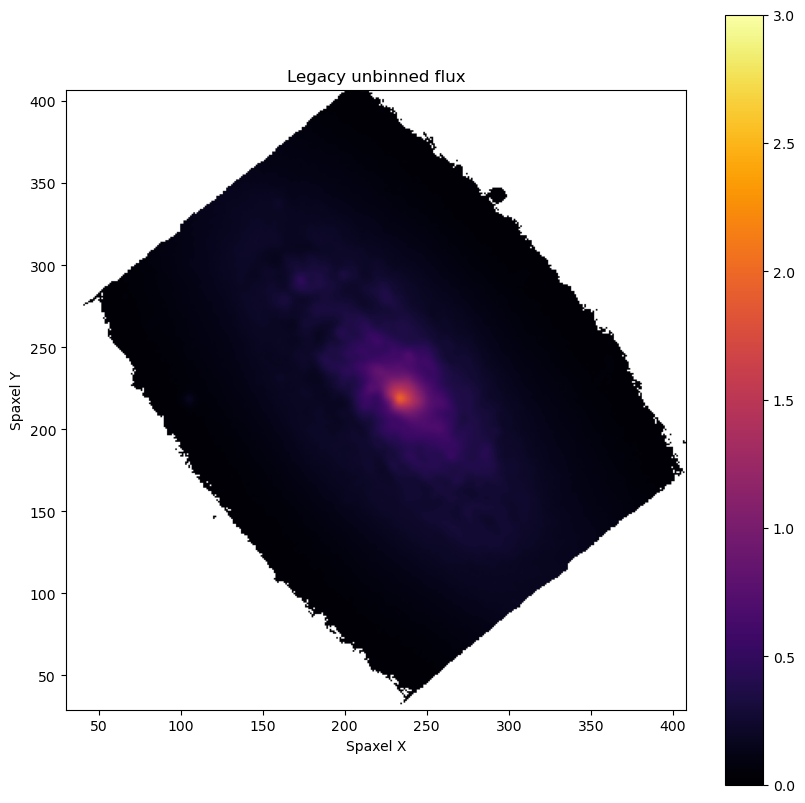

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(cube_out[1], cmap='inferno', origin='lower', vmin=0, vmax=3)
plt.title('Legacy unbinned flux')
plt.colorbar()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

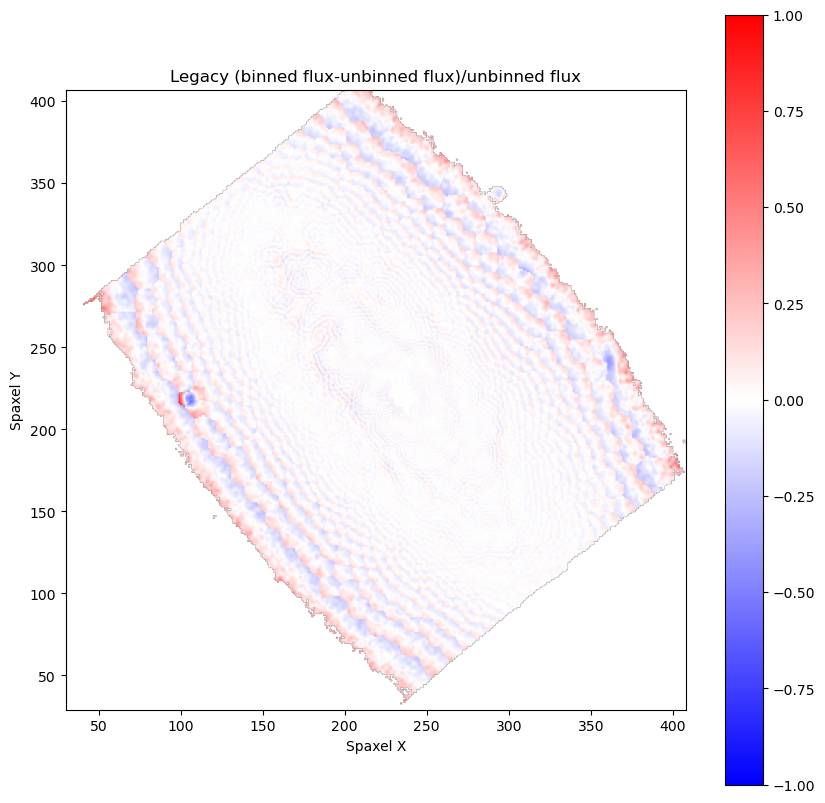

In [19]:
# Plot the (binned flux-unbinned flux)/unbinned flux
plt.figure(figsize=(10, 10))
plt.imshow((flux_map[1]-cube_out[1])/cube_out[1], cmap='bwr', origin='lower', vmin=-1, vmax=1)
plt.title('Legacy (binned flux-unbinned flux)/unbinned flux')
plt.colorbar()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

Filename: IC3392_DESI_grih.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (3000, 3000, 4)   float32   
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                 3000 / length of data axis 1                          NAXIS2  =                 3000 / length of data axis 2                          NAXIS3  =                    4 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H SURVEY  = 'LegacySurvey'                                                        VERSION = 'DR10    '               

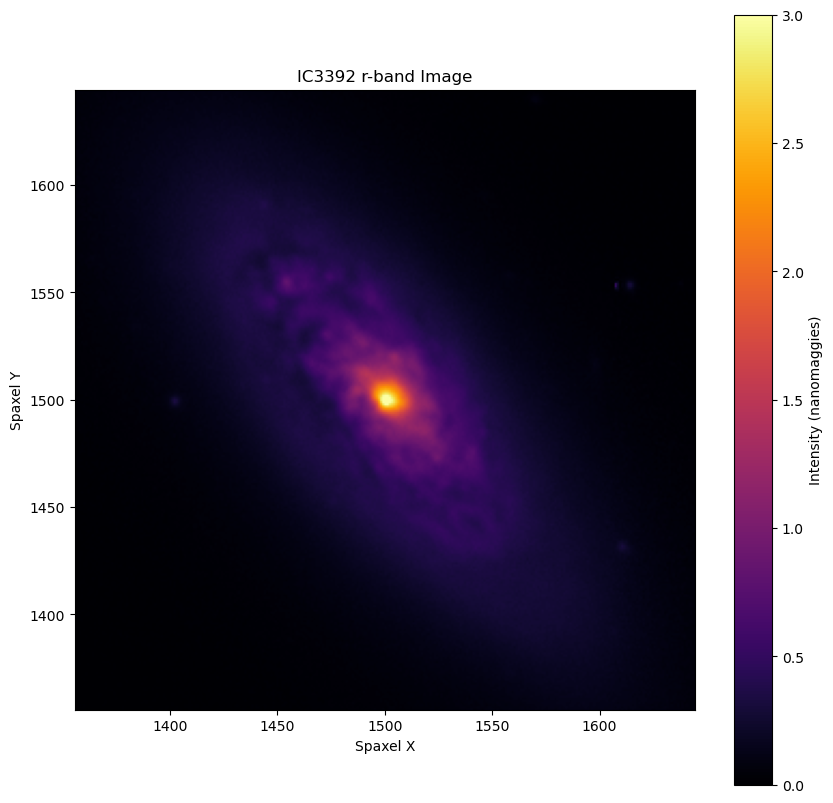

In [20]:
# Load the FITS file (update the filename as needed)
filename = "IC3392_DESI_grih.fits"
object_name = filename.split('_')[0]
hdul = fits.open(filename)

# Display the structure of the FITS file
hdul.info()

# Assuming the image data is in the primary HDU (index 0)
data = hdul[0].data

# Optionally, print header information to see details about the observation
header = hdul[0].header
print(header)

# Close the FITS file after loading data (optional but recommended)
hdul.close()

g_band_flux = data[0]  # Assuming the first slice is the g-band flux
r_band_flux = data[1]  # Assuming the first slice is the r-band flux
i_band_flux = data[2]  # Assuming the second slice is the i-band flux
h_band_flux = data[3]  # Assuming the second slice is the h-band flux

# Plot the data using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(r_band_flux, cmap='inferno', origin='lower', vmin=0, vmax=3)
plt.colorbar(label='Intensity (nanomaggies)')
plt.title(f"{object_name} r-band Image")
plt.xlim(r_band_flux.shape[0]/2-0.2/0.262*half_zoom, r_band_flux.shape[0]/2+0.2/0.262*half_zoom)
plt.ylim(r_band_flux.shape[0]/2-0.2/0.262*half_zoom, r_band_flux.shape[0]/2+0.2/0.262*half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()